In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# import statsmodels
from scipy.stats import fisher_exact, chi2_contingency

from matplotlib.transforms import Affine2D
import matplotlib
import seaborn as sns
import sys
import os
from os import path
import yaml
import copy
from scipy import stats
from statsmodels.stats.contingency_tables import Table2x2
from importlib import reload
import pickle
import PIL

In [2]:
# riskratio_confint
from statsmodels.stats.contingency_tables import Table2x2
from statsmodels.stats.proportion import proportion_confint
from statsmodels.stats.proportion import proportions_ztest


# Import Data



In [3]:
# complete path_to_file:

path_to_file = r'D:\Ali USB Backup\Special\combined religion vs speciality (1).xlsx'

df_GMC = pd.read_excel(path_to_file, sheet_name = 'GMC data', usecols="A:J", nrows=14, index_col=0, engine='openpyxl')  # non-indexed
df_HEE = pd.read_excel(path_to_file, sheet_name = 'HEE data combined', usecols="A:J", nrows=14, index_col=0, engine='openpyxl')  # non-indexed


In [4]:

df_HEE

,Atheism,Buddhism,Christianity,Hinduism,islam,judaism,sikh,other,unknown
Anaesthetics,307,12,239,71,70,6,9,40,153
Emergency medicine,300,24,283,103,259,6,10,48,166
GP,902,149,2060,533,1579,17,65,247,975
Medicine,464,177,635,226,899,20,30,91,442
O&G,108,24,302,93,263,6,9,29,105
occupational medicine,2,0,12,2,3,1,0,3,2
opthalmology,49,9,95,21,81,3,3,21,86
Paediatrics,155,19,316,76,266,6,4,40,118
pathology,33,2,52,13,31,2,0,13,38
Pschiatry,133,17,166,39,101,0,6,33,88


In [5]:
df_GMC

,Atheism,buddhist,christian,hindu,muslim,jewish,sikh,other,unknown and prefer not to say
anaesthesia,1278,45,1537,486,197,31,25,38,6850
Emergency Medicine,369,10,449,96,102,11,7,6,1358
GP,5225,174,7632,1364,1789,175,282,187,46649
Medicine,2116,141,3350,845,856,121,58,93,13745
Obs&gyne,334,19,806,292,190,12,11,16,2390
occupational medicine,68,0,120,9,8,2,0,1,359
opthalmology,181,14,404,105,100,9,8,12,1508
paediatrics,585,38,1120,446,204,35,9,34,3521
pathology,314,21,403,120,87,16,7,10,2035
psychiatry,936,51,1074,426,301,56,37,63,5264


In [6]:
# first rename indices and columns

df_HEE = df_HEE.rename(index={
                            'Anaesthetics': 'Anaesthetics & ITU',
                            'occupational medicine':'Occupational Med',
                             'opthalmology':'Ophthalmology',
                              'pathology':'Pathology',
                              'Pschiatry': 'Psychiatry',
                              'public health': 'Public Health',
                              'radiology': 'Radiology',
                              'other' : 'Other',
                              'Emergency medicine': 'Emergency Medicine',
                                'O&G' : 'Obs & Gynae',
                             }, 
                       columns={
                               'Atheism':'Atheist',
                               'Buddhism': 'Buddhist',
                               'Christianity': 'Christian',
                               'Hinduism': 'Hindu',
                               'islam': 'Muslim',
                                'judaism': 'Jewish',
                           'sikh':'Sikh',
                           'other': 'Other Faiths',
                           'unknown': 'Unknown',
                                                         
                       })



df_GMC = df_GMC.rename(index={
                            'anaesthesia': 'Anaesthetics & ITU',
                            'Obs&gyne' : 'Obs & Gynae',
                            'occupational medicine':'Occupational Med',
                             'opthalmology':'Ophthalmology',
                            'paediatrics': 'Paediatrics',
                              'pathology':'Pathology',
                              'psychiatry': 'Psychiatry',
                              'publice health': 'Public Health',
                              'radiology': 'Radiology',
                            'surgery': 'Surgery',
                              'other' : 'Other',
                             }, 
                       columns={
                               'Atheism':'Atheist',
                               'buddhist': 'Buddhist',
                               'christian': 'Christian',
                               'hindu': 'Hindu',
                               'muslim': 'Muslim',
                                'jewish': 'Jewish',
                           'sikh':'Sikh',
                           'other': 'Other Faiths',
                           'unknown and prefer not to say': 'Unknown',
                                                         
                       })


# Forest Plot function

In [7]:
def plot_RR_ci_forest_plot(
                                    df1,
                                   confint_df_1,
                                   counts_df_1,
                                   colors,
                                   legend_labels,
                                   df2,
                                   confint_df_2,
                                   counts_df_2,
                                   y_labels=None,
                                   overlapping=False,
                                   ax_titles=None,
                                   xlim=[-0.05, 10],
                                   xticks=None,
                                   vline= 1, # 'proportion',
                                   xlabel= 'Relative Risk (99.5% CI)',
                                   figsize=(7, 8),
                                   plotter_settings=None,
                                   fontsize=8,
                                    legend_fontsize=10,
                                    lin_or_log = 'linear,'
                                   ):
    """
    Plot a forest plot of RR and confidence intervals. Can be two sets of data points
    (different colours) on each axis.

    If only one set of points, set RR_GMC_2, confint_df_2, counts_df_2 = None

    localising_n = query_results from figures.ipynb
    """
    df1 = df1.T
    confint_df_1[0] = confint_df_1[0].T
    confint_df_1[1] = confint_df_1[1].T
    counts_df_1 = counts_df_1.T
    
    df2 = df2.T
    confint_df_2[0] = confint_df_2[0].T
    confint_df_2[1] = confint_df_2[1].T
    counts_df_2 = counts_df_2.T
    
    n_rows, n_columns = df1.shape
    # axes are in 3 rows, subplot_width columns
    subplot_width = int(n_rows / 3) + (n_rows % 3 > 0)

    fig, axs = plt.subplots(subplot_width, 3, sharex=True,
                            sharey=True, figsize=figsize)
    
    if not y_labels:
        y_labels = df1.columns

    for i, row_name in enumerate(df1.index):
        # Plot on one axis at a time
        coord = divmod(i, 3)
        ax = axs[coord[0], coord[1]]
        
        if not overlapping and df2 is not None:
            trans1 = Affine2D().translate(0, -0.1) + ax.transData
            trans2 = Affine2D().translate(0, +0.1) + ax.transData
            transforms = [trans1, trans2]
        else:
            transforms = [None, None]

        # Plot first data points (potentially one of two)
        x = df1.loc[row_name]
        xerr = np.array([confint_df_1[0].loc[row_name].values,
                         confint_df_1[1].loc[row_name].values])
        
        if row_name != 'Muslim':
            color_ci=colors[0]
        elif row_name == 'Muslim':
            color_ci=colors[0]
            
        ax.errorbar(x,
                    y_labels,
                    xerr=xerr,
                    color=color_ci,
                    label=legend_labels[0],
                    transform=transforms[0],
                    markerfacecolor='white',
                    **plotter_settings)

        total_row_1 = int(counts_df_1.loc[row_name].sum())
        n_label_text = f' (n = {total_row_1}$^H$'

        # Plot second set of datapoints (usually second colour, might be SS only)
        if df2 is not None:
            x = df2.loc[row_name]
            xerr = np.array([confint_df_2[0].loc[row_name].values,
                             confint_df_2[1].loc[row_name].values])
            ax.errorbar(x,
                        y_labels,
                        xerr=xerr,
                        color = colors[1], #comment out for default blue
                        label=legend_labels[1],
                        transform=transforms[1],
                        **plotter_settings)

            total_row_2 = int(counts_df_2.loc[row_name].sum())
            n_label_text += f', {total_row_2}$^G$'
           

        try:
#             ax.title.set_text(ax_titles[i] + n_label_text + ')')
            ax.set_title(ax_titles[i] + n_label_text + ')',
                         fontdict={'fontsize': fontsize})
        except TypeError:
#             ax.title.set_text(row_name + n_label_text + ')')
            ax.set_title(row_name + n_label_text + ')',
                         fontdict={'fontsize': fontsize})
#         elif localising_n:
#             ax.set_title(row_name + n_label_text + ')',
#                          fontdict={'fontsize': fontsize})

        ax.set_xlim(xlim)
        
        
        if vline == 'proportion':
            ax.axvline(x=1/len(x), ymin=0, ymax=1, c='darkgray',
                       linewidth=1, zorder=0, clip_on=False)
        else:
            ax.axvline(x=vline, c='black',
                       linewidth=1, zorder=0, clip_on=False)

    ax.invert_yaxis()

    axs[subplot_width-1, 1].set_xlabel(xlabel, ha='center')
    plt.legend(loc='lower right', fontsize=legend_fontsize)
    plt.xscale(lin_or_log)    
    if lin_or_log != 'log':
        plt.xticks(xticks)
    plt.tight_layout()

    return fig, axs

# 1. Obtain the contingency matrix of interest

In [8]:
def get_contingency_from_data(df, specialty, religion):
    """
    see supplementary materials. 
    in the form:
    [[a, b],
     [c, d]]
    """
    a = df.loc[specialty, religion]
    b = df[religion].sum() - a
    c = df.loc[specialty, :].sum() - a
    d = (df.sum().sum() - df.loc[specialty, :].sum()) - b
    
    contingency_table = np.array(
        [[a, b],
        [c, d]]
    )
    
    chi2, p, dof, exp = chi2_contingency(contingency_table)
    
    ct = Table2x2(contingency_table)
    RR = ct.riskratio 
    OR = ct.oddsratio
    CI_RR = ct.riskratio_confint(alpha=0.005, method='normal')
    OR_CI = ct.oddsratio_confint()
    
#     print('RR', round(RR, 2), '95% CI', round(CI[0], 2), round(CI[1], 2))
#     print ('chi2', round(chi2, 1), f'p {p:.2e}', 'dof', dof)
    return contingency_table, chi2, p, dof, exp, OR, OR_CI, RR, CI_RR

In [9]:
def printround(item):
    return round(item,2)

# 2. HEE: RRs & ORs with CIs 

### odds ratios preferred esp when we don't know a significant portion of the religious affiliations (GMC>>HEE) (use especially when excluding unknowns as per 4 below)

### can use RR if not using 4 below, but note for GMC (3 below) lots of uknowns

#### note these p values are uncorrected, see other notebook

In [10]:
RR_HEE_1 = pd.DataFrame().reindex_like(df_HEE)
confint_df_1 = dict()
confint_df_1[0] = pd.DataFrame().reindex_like(df_HEE)
confint_df_1[1] = pd.DataFrame().reindex_like(df_HEE)
    
for i, specialty in enumerate(df_HEE.index):
    for religion in df_HEE.columns:
        c_t, chi2, p, dof, exp, OR, OR_CI, RR, CI_RR = get_contingency_from_data(df_HEE, specialty, religion)

        RR_HEE_1.loc[specialty, religion] = round(RR, 2)
        confint_df_1[0].loc[specialty, religion] = round(CI_RR[0], 2)
        confint_df_1[1].loc[specialty, religion] = round(CI_RR[1], 2)

In [11]:
confint_df_1[0] = (RR_HEE_1 - confint_df_1[0])

In [12]:
confint_df_1[1] = (confint_df_1[1] - RR_HEE_1)

# 3. GMC: RRs & ORs with CIs

In [13]:
RR_GMC_2 = pd.DataFrame().reindex_like(df_GMC)
confint_df_2 = dict()
confint_df_2[0] = pd.DataFrame().reindex_like(df_GMC)
confint_df_2[1] = pd.DataFrame().reindex_like(df_GMC)
    
for i, specialty in enumerate(df_GMC.index):
    for religion in df_GMC.columns:
        c_t, chi2, p, dof, exp, OR, OR_CI, RR, CI_RR = get_contingency_from_data(df_GMC, specialty, religion)

        RR_GMC_2.loc[specialty, religion] = round(RR, 2)
        confint_df_2[0].loc[specialty, religion] = round(CI_RR[0], 2)
        confint_df_2[1].loc[specialty, religion] = round(CI_RR[1], 2)


In [14]:
confint_df_2[0] = (RR_GMC_2 - confint_df_2[0])

In [15]:
confint_df_2[1] = (confint_df_2[1] - RR_GMC_2)

# Plot

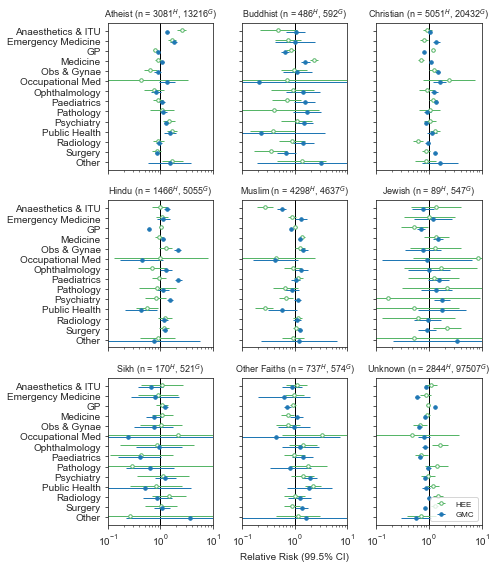

In [16]:
sns.set_style('ticks')
plotter_settings = {
    'ls': 'none',
    'linewidth': 1,
    'marker': 'o',
    'markeredgewidth': 1,
    'markersize': 3.5,
#     'markerfacecolor': 'white',
#     'alpha': 0.5
}

fig, axs = plot_RR_ci_forest_plot(
                               df1 = RR_HEE_1,
                               confint_df_1 = confint_df_1,
                               counts_df_1 = df_HEE,
                               colors = [sns.color_palette("Greens")[3], sns.color_palette()[0]],
                               legend_labels = ['HEE', 'GMC'],
                               df2 = RR_GMC_2,
                               confint_df_2 = confint_df_2,
                               counts_df_2 = df_GMC,
                               y_labels = None, # labels.clean_localisations(results['full']['proportion'].columns),
                               overlapping=False,
                               ax_titles = None, # labels.clean_semiologies(results['full']['proportion'].index),
                               plotter_settings = plotter_settings,
                               xlim = [0.1, 10],
                               xticks = np.arange(0.1, 10, 2), #[0, 5, 6],  # np.arange(0, 3, 2), currently commented out in main function
                                vline=1.0,
                                fontsize=9,
                                legend_fontsize=8,
                                lin_or_log = 'log',
                                # figsize = (7, 9),
                              )
# plt.savefig(r'D:\Ali USB Backup\Special\995% normal log v1 ticks.eps', dpi=300, pad_inches=0.5)
# plt.savefig(r'D:\Ali USB Backup\Special\995% normal log v1 ticks.png', dpi=300, pad_inches=0.5)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


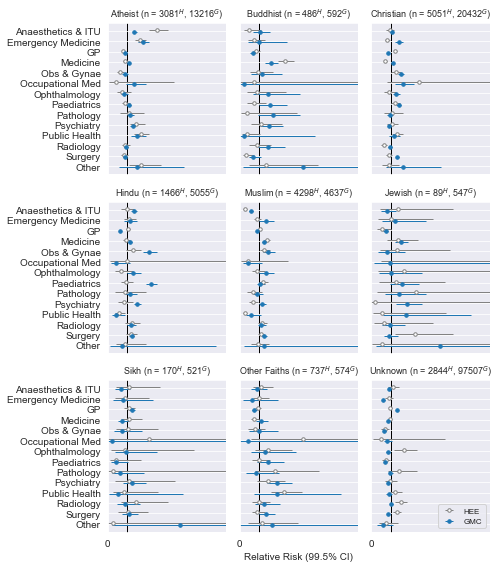

In [18]:
sns.set_style('darkgrid')
plotter_settings = {
    'ls': 'none',
    'linewidth': 1,
    'marker': 'o',
    'markeredgewidth': 1,
    'markersize': 3.5,
#     'markerfacecolor': 'white',
#     'alpha': 0.5
}

fig, axs = plot_RR_ci_forest_plot(
                               df1 = RR_HEE_1,
                               confint_df_1 = confint_df_1,
                               counts_df_1 = df_HEE,
                               colors = [sns.color_palette("Greys")[3], sns.color_palette()[0]],
                               legend_labels = ['HEE', 'GMC'],
                               df2 = RR_GMC_2,
                               confint_df_2 = confint_df_2,
                               counts_df_2 = df_GMC,
                               y_labels = None, # labels.clean_localisations(results['full']['proportion'].columns),
                               overlapping=False,
                               ax_titles = None, # labels.clean_semiologies(results['full']['proportion'].index),
                               plotter_settings = plotter_settings,
                               xlim = [0, 6],
                               xticks = np.arange(0, 6.1, 7), #[0, 5, 6],  # np.arange(0, 3, 2), currently commented out in main function
                                vline=1.0,
                                fontsize=9,
                                legend_fontsize=8,
                                lin_or_log = 'linear',
                                # figsize = (7, 9),
                              )
# plt.savefig(r'D:\Ali USB Backup\Special\995% normal linear v2 dark greys.eps', dpi=300, pad_inches=0.5)
# plt.savefig(r'D:\Ali USB Backup\Special\995% normal linear v2 dark greys.png', dpi=300, pad_inches=0.5)

# 5. ok so above uses unknowns, we now need to check the magnitude of these effects with sensitivity analyses

## 5.1 removing unknowns

In [ ]:
# simply run this then run above again:
# df_HEE.drop(columns=['unknown'], inplace=True)

In [ ]:
# df_GMC.drop(columns=['unknown and prefer not to say'], inplace=True)

## 5.2 redistributing unknowns based on UK Doctor's Data